# 1D Advection-Diffusion Equation

In this notebook, we will implement finite difference schemes to solve the 1D partial differential equation for advection and diffusion of a tracer:

$$ \frac{\partial C}{\partial t} + u\frac{\partial C}{\partial x} = \kappa\frac{\partial^{2} C}{\partial x^{2}}$$

where $C$ is a tracer, such as temperature, salinity, dye concentration, $u$ is the flow velocity experienced by the tracer, and $\kappa$ is the diffusion coefficient (diffusivity) of the fluid. As before, we assume diffusivity is constant and uniform. 

***

### Ideas for what to explore:
- Plot the solutions using these schemes together.
- What happens to the stability in FTCS if $u$ is larger? Or if diffusivity is larger?
- How do BTCS and Crank-Nicholson schemes respond to those changes?
- Do the solutions become more numerically diffuse as the scheme becomes (overly) stable?

### Forward Time Centered Space (FTCS)

In [54]:
import numpy as np
from scipy.special import erfc
import matplotlib.pyplot as plt

First, define the solution space and parameters, and initialize the matrices.

In [95]:
# define the solution space
x0 = 0
xL = 250
L = xL-x0

# define the spatial discretization
n = 249
dx = L/(n+1)
x = np.arange(x0,xL,dx)

# define the temporal discretization
m = 7300
T = 365 
dt = T/m

# define parameters
u = 0.1
kappa = 0.5

# initial conditions
c0 = 1

# define Courant numbers
D = kappa*dt/(dx**2)
S = u*dt/dx
print('D = ',D)
print('S = ',S)

D =  0.025
S =  0.005000000000000001


In [96]:
# initialize the matrices
A = np.zeros((n,n))

for i in range(n):
    if i == 0:
        A[i, i] = 1-(2*D)
        A[i, i+1] = D-(S/2)
    elif i == n-1:
        A[i, i-1] = D+(S/2)
        A[i, i] = 1-(2*D)
    else:
        A[i, i] = 1-(2*D)
        A[i, i-1] = D+(S/2)
        A[i, i+1] = D-(S/2)

B = np.zeros((n, 1))

Next, impose boundary conditions.

In [97]:
# apply Dirichlet BCs
B[0] = c0*(D+(S/2))
B[n-1] = 0*(D-(S/2))

Create the spatial discretization.

In [98]:
x = np.arange(x0+dx,xL,dx)
t0 = 0

Initialize solution matrices and impose initial condition.

In [99]:
C = np.empty((m, n))
C_xt = np.zeros_like(x)
C[0, :] = C_xt
t = np.zeros((m))
t[0] = t0

Finally, march forward in time.

In [100]:
for i in range(m-1):
    C_n = np.matmul(A, C_xt[:, np.newaxis]) + B
    C[i+1, :] = C_n.flatten()
    C_xt = C_n.flatten()
    t[i+1] = t[i] + dt

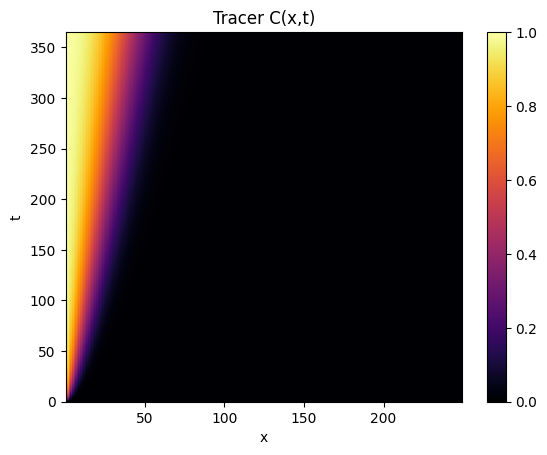

In [101]:
fig, ax = plt.subplots(1)
c = ax.pcolormesh(x, t, C, cmap='inferno', vmin=0, vmax=1)
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_title('Tracer C(x,t)')
plt.colorbar(c)

Text(0.5, 1.0, 'Tracer C at t=T')

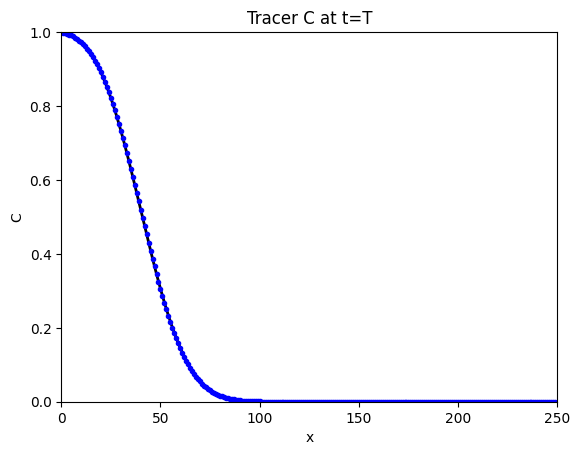

In [103]:
# Analytical solution
C_ana = c0/2 * (erfc((x-u*T)/(2*np.sqrt(kappa*T))) + np.exp(u*x/kappa) * erfc((x+u*T)/(2*np.sqrt(kappa*T))))

fig, ax = plt.subplots(1)
ax.plot(x, C_ana, 'k', lw=2)
ax.plot(x, C[-1, :], 'b.', lw=1)
#ax.set_xscale('log')
ax.set_xlim([0, 250])
ax.set_ylim([0, 1])
ax.set_xlabel('x')
ax.set_ylabel('C')
ax.set_title('Tracer C at t=T')

### Backward Time Centered Space (BTCS)


In [104]:
# initialize the matrices
A = np.zeros((n,n))

for i in range(n):
    if i == 0:
        A[i, i] = 1+(2*D)
        A[i, i+1] = (S/2)-D
    elif i == n-1:
        A[i, i-1] = -((S/2)+D)
        A[i, i] = 1+(2*D)
    else:
        A[i, i] = 1+(2*D)
        A[i, i-1] = -((S/2)+D)
        A[i, i+1] = (S/2)-D

B = np.zeros((n, 1))

Next, impose boundary conditions.

In [105]:
# apply Dirichlet BCs
B[0] = c0*((S/2)+D)
B[n-1] = 0*((S/2)-D)

Create the spatial discretization.

In [106]:
x = np.arange(x0+dx,xL,dx)
t0 = 0

Initialize solution matrices and impose initial condition.


In [107]:
C = np.empty((m, n))
C_xt = np.zeros_like(x)
C[0, :] = C_xt
t = np.zeros((m))
t[0] = t0

Finally, march forward in time.

In [108]:
IA = np.linalg.inv(A)
for i in range(m-1):
    tempC = (C_xt[:, np.newaxis] + B)
    C_n = np.matmul(IA, tempC)
    C[i+1, :] = C_n.flatten()
    C_xt = C_n.flatten()
    t[i+1] = t[i] + dt

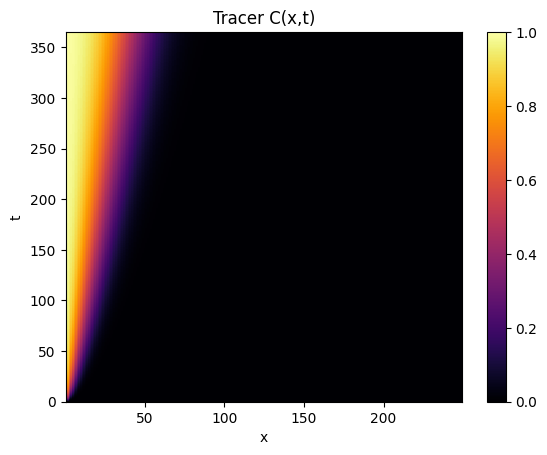

In [109]:
fig, ax = plt.subplots(1)
c = ax.pcolormesh(x, t, C, cmap='inferno', vmin=0, vmax=1)
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_title('Tracer C(x,t)')
plt.colorbar(c)

Text(0.5, 1.0, 'Tracer C at t=T')

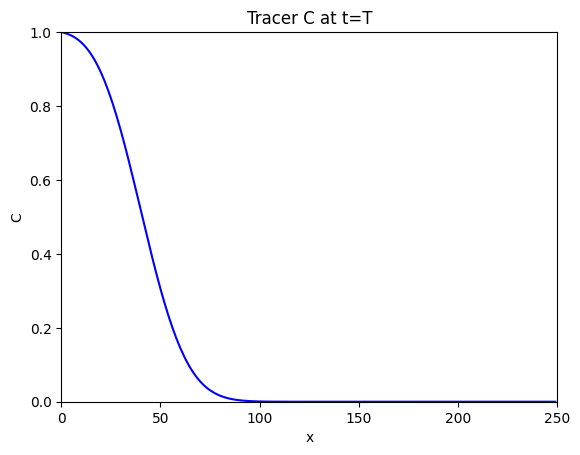

In [110]:
fig, ax = plt.subplots(1)
ax.plot(x, C[-1, :], 'b')
ax.set_xlim([0, 250])
ax.set_ylim([0, 1])
ax.set_xlabel('x')
ax.set_ylabel('C')
ax.set_title('Tracer C at t=T')

### Crank-Nicholson

In [111]:
# initialize the matrices
A1 = np.zeros((n,n))
A2 = np.zeros((n,n))

for i in range(n):
    if i == 0:
        A1[i, i] = 2+2*D
        A1[i, i+1] = (S/2)-D
        A2[i, i] = 2-2*D
        A2[i, i+1] = D-(S/2)
    elif i == n-1:
        A1[i, i-1] = -((S/2)+D)
        A1[i, i] = 2+(2*D)
        A2[i, i-1] = (S/2)+D
        A2[i, i] = 2-(2*D)
    else:
        A1[i, i] = 2+(2*D)
        A1[i, i-1] = -((S/2)+D)
        A1[i, i+1] = (S/2)-D
        A2[i, i] = 2-(2*D)
        A2[i, i-1] = ((S/2)+D)
        A2[i, i+1] = D-(S/2)
B1 = np.zeros((n, 1))
B2 = np.zeros((n, 1))

In [112]:
# apply Dirichlet BCs
B1[0] = -c0*(D+(S/2))
B1[n-1] = 0*((S/2)-D)
B2[0] = c0*(D+(S/2))
B2[n-1] = 0*((S/2)-D)

In [113]:
x = np.arange(x0+dx,xL,dx)
t0 = 0

In [114]:
C = np.empty((m, n))
C_xt = np.zeros_like(x)
C[0, :] = C_xt
t = np.zeros((m))
t[0] = t0

In [115]:
IA1 = np.linalg.inv(A1)
for i in range(m-1):
    tempC = np.matmul(A2, C_xt[:, np.newaxis]) + B2 - B1
    C_n = np.matmul(IA1, tempC)
    C[i+1, :] = C_n.flatten()
    C_xt = C_n.flatten()
    t[i+1] = t[i] + dt

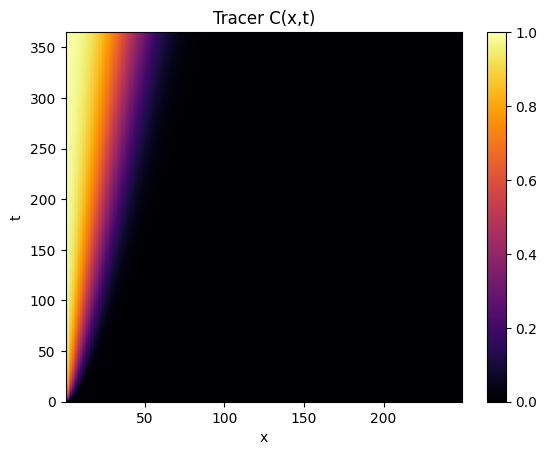

In [116]:
fig, ax = plt.subplots(1)
c = ax.pcolormesh(x, t, C, cmap='inferno', vmin=0, vmax=1)
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_title('Tracer C(x,t)')
plt.colorbar(c)